## NOTES TO SELF:

- Should have a discussion about the difficulty of handling unseen words in
  novel situations. Find research papers discussing this.

## Resources
- [Medium Article](https://towardsdatascience.com/word2vec-with-pytorch-implementing-original-paper-2cd7040120b0)
- [Github Project](https://github.com/OlgaChernytska/word2vec-pytorch)
- [Visualizing Word Embeddings](https://towardsdatascience.com/visualization-of-word-embedding-vectors-using-gensim-and-pca-8f592a5d3354)



## OUTLINE OF FINAL DOC:

- Introduction
- Data
- Data Preparation
- Building the Network
  - Architecture & Hyperparameters
- Validating the Performance
- References

In [134]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from collections import Counter
from functools import partial
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


In [135]:
# NOTE: If running this locally in an environment that has not yet setup nltk,
# need to run this code here.
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

In [136]:

# Step 0: How big is this dataset? How big is this corpus?

data = pd.read_csv('./wiki_movie_plots_deduped.csv')

data.shape, data.columns

((34886, 8),
 Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
        'Genre', 'Wiki Page', 'Plot'],
       dtype='object'))

## PyTorch Pre-Processor / Tokenizer

In [137]:
train_mask = np.random.rand(len(data)) < 0.8
train_data = data[train_mask]["Plot"]
val_data = data[~train_mask]["Plot"]


In [138]:
CBOW_N_WORDS = 4
MAX_SEQUENCE_LENGTH = 256

def collate_cbow(batch, text_pipeline):
    batch_input = []
    batch_output = []

    for text in batch:
        text_tokens_ids = text_pipeline(text)

        if len(text_tokens_ids) < CBOW_N_WORDS * 2 + 1:
            continue

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - CBOW_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + CBOW_N_WORDS * 2 + 1)]
            # Pop the word in the middle of the sequence.
            output = token_id_sequence.pop(CBOW_N_WORDS)
            input_ = token_id_sequence
            batch_input.append(input_)
            batch_output.append(output)

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)

    return batch_input, batch_output



In [139]:
def build_dataloader(data_iter, batch_size, vocab = None):
    MIN_WORD_FREQUENCY=10

    tokenizer = get_tokenizer("basic_english", language="en")

    token_lists = map(tokenizer, data_iter)
    word_counts = Counter()

    if vocab is None:
        vocab = build_vocab_from_iterator(
            map(tokenizer, data_iter),
            specials=["<unk>"],
            min_freq=MIN_WORD_FREQUENCY
        )

        vocab.set_default_index(vocab["<unk>"])

    for tokens in token_lists:
        for token in tokens:
            word_counts[token] += 1

    def text_pipeline(x):
        return vocab(tokenizer(x))

    dataloader = DataLoader(
        data_iter,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=partial(collate_cbow, text_pipeline=text_pipeline)
    )

    return dataloader, word_counts, vocab



In [140]:

EMBED_MAX_NORM = 1

class CBOWModel(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int):
        super(CBOWModel, self).__init__()

        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            max_norm=EMBED_MAX_NORM
        )

        self.linear = nn.Linear(
            in_features=embedding_dim,
            out_features=vocab_size
        )


    def forward(self, inputs_):
        x = self.embeddings(inputs_)
        x = x.mean(axis=1)
        x = self.linear(x)
        return x



In [141]:
BATCH_SIZE=50

train_dataloader, train_word_counts, vocab = build_dataloader(
    data_iter=train_data.values,
    batch_size=BATCH_SIZE
)

val_dataloader, val_word_counts, _ = build_dataloader(
    data_iter=val_data.values,
    batch_size=BATCH_SIZE,
    vocab=vocab
)


In [142]:

# Code taken from here:
# https://github.com/OlgaChernytska/word2vec-pytorch/blob/main/utils/trainer.py

class Trainer:
    def __init__(
        self,
        model,
        epochs,
        train_dataloader,
        train_steps,
        val_dataloader,
        val_steps,
        criterion,
        optimizer,
        lr_scheduler
    ):
        self.model = model
        self.epochs = epochs
        self.train_dataloader = train_dataloader
        self.train_steps = train_steps
        self.val_dataloader = val_dataloader
        self.val_steps = val_steps
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler

        self.loss = {"train": [], "val": []}


    def train(self):
        for epoch in range(self.epochs):
            self._train_epoch()
            self._validate_epoch()

            print(
                "Epoch: {}/{}, Train Loss={:.5f}, Val Loss={:.5f}".format(
                    epoch + 1,
                    self.epochs,
                    self.loss["train"][-1],
                    self.loss["val"][-1]
                )
            )

            if self.lr_scheduler is not None:
                self.lr_scheduler.step()

    
    def _train_epoch(self):
        self.model.train()

        running_loss = []

        for i, batch_data in enumerate(self.train_dataloader, 1):
            inputs = batch_data[0]
            labels = batch_data[1]

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss.append(loss.item())

            if i == self.train_steps:
                break

        epoch_loss = np.mean(running_loss)
        self.loss["train"].append(epoch_loss)

    def _validate_epoch(self):
        self.model.eval()
        running_loss = []

        with torch.no_grad():
            for i, batch_data in enumerate(self.val_dataloader, 1):
                inputs = batch_data[0]
                labels = batch_data[1]

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss.append(loss.item())

                if i == self.val_steps:
                    break

        epoch_loss = np.mean(running_loss)
        self.loss["val"].append(epoch_loss)
        

In [143]:
MODEL_PATH = os.path.join('outputs', 'model.pt')
LOSS_PATH = os.path.join('outputs', 'loss.json')

def save_model(model):
    torch.save(model, MODEL_PATH)


def load_model():
    return torch.load(MODEL_PATH)


def save_loss(loss):
    with open(LOSS_PATH, 'w') as fp:
        json.dump(loss, fp)


def load_loss():
    with open(LOSS_PATH) as fp:
        loss = json.load(fp)

    return loss


In [144]:
EPOCHS=50
LR=0.05

model = CBOWModel(vocab_size=len(vocab), embedding_dim=300)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

lr_lambda = lambda epoch: (EPOCHS - epoch) / EPOCHS
lr_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda, verbose=True)

trainer = Trainer(
    model=model,
    epochs=EPOCHS,
    train_dataloader=train_dataloader,
    train_steps=10,
    val_dataloader=val_dataloader,
    val_steps=10,
    criterion=criterion,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler
)

trainer.train()
print("Training finished")

save_model(model)
save_loss(trainer.loss)
print("Data Saved")

    

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch: 1/50, Train Loss=8.46127, Val Loss=7.10379
Adjusting learning rate of group 0 to 4.9000e-02.
Epoch: 2/50, Train Loss=7.02065, Val Loss=6.83058
Adjusting learning rate of group 0 to 4.8000e-02.
Epoch: 3/50, Train Loss=6.82693, Val Loss=6.68818
Adjusting learning rate of group 0 to 4.7000e-02.
Epoch: 4/50, Train Loss=6.70563, Val Loss=6.58543
Adjusting learning rate of group 0 to 4.6000e-02.
Epoch: 5/50, Train Loss=6.56456, Val Loss=6.50408
Adjusting learning rate of group 0 to 4.5000e-02.
Epoch: 6/50, Train Loss=6.54804, Val Loss=6.44678
Adjusting learning rate of group 0 to 4.4000e-02.
Epoch: 7/50, Train Loss=6.49135, Val Loss=6.39637
Adjusting learning rate of group 0 to 4.3000e-02.
Epoch: 8/50, Train Loss=6.41186, Val Loss=6.36856
Adjusting learning rate of group 0 to 4.2000e-02.
Epoch: 9/50, Train Loss=6.41082, Val Loss=6.31875
Adjusting learning rate of group 0 to 4.1000e-02.
Epoch: 10/50, Train Loss=6.35353, Val Loss=6.29027

In [145]:
# model = load_model()
# loss = load_loss()

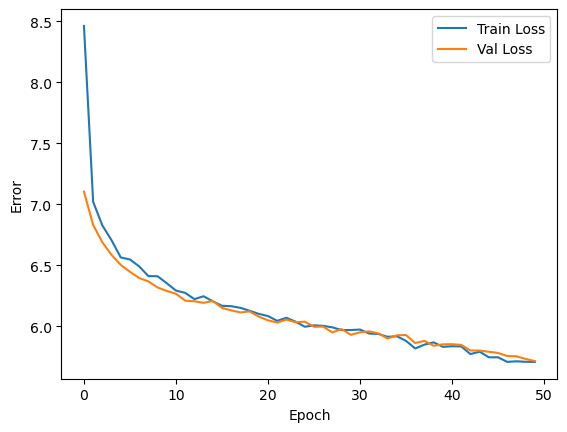

In [146]:
loss = trainer.loss
plt.plot(loss['train'], label='Train Loss')
plt.plot(loss['val'], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

In [147]:

def k_nearest_words(model, vocab, word, k):
    word_index = vocab([word])[0]
    num_embeddings = model.embeddings.num_embeddings
    word_embedding = model.embeddings(torch.Tensor([word_index]).type(torch.long))

    k_closest_indices = []
    k_closest_norms = []

    for index in range(num_embeddings):
        if index == word_index:
            continue

        compare_embedding = model.embeddings(torch.Tensor([index]).type(torch.long))
        diff = compare_embedding - word_embedding
        norm = torch.linalg.norm(diff).item()

        if len(k_closest_indices) < k:
            k_closest_indices.append(index)
            k_closest_norms.append(norm)
        else:
            for i in range(k):
                if norm < k_closest_norms[i]:
                    k_closest_indices[i] = index
                    k_closest_norms[i] = norm
                    break

    return [vocab.lookup_token(index) for index in k_closest_indices]

    

In [133]:
k_nearest_words(model, vocab, 'steal', 5)

['rescue', 'join', 'sabotage', 'persuade', 'locate']

In [127]:
# PCA 2D

embeddings_np = model.embeddings.weight.detach().numpy()
df = pd.DataFrame(embeddings_np, index=vocab.get_itos())

X_corr = df.corr()
values, vectors = np.linalg.eig(X_corr)
args = (-values).argsort()
values = vectors[args]
vectors = vectors[:, args]

# Taking first 2 components which explain maximum variance for projecting.
new_vectors = vectors[:, :2]

# Projecting it onto new dimension with 2 axis
neww_X = np.dot(embeddings_np, new_vectors)
neww_X


ValueError: Shape of passed values is (23659, 300), indices imply (36367, 300)

In [125]:
# Taken from here:
# https://towardsdatascience.com/visualization-of-word-embedding-vectors-using-gensim-and-pca-8f592a5d3354

NUM_WORDS_TO_DISPLAY = 100
pick_indices = np.random.randint(0, len(vocab) - 1, NUM_WORDS_TO_DISPLAY)

plt.figure(figsize=(13, 7))
plt.scatter(neww_X[pick_indices, 0], neww_X[pick_indices, 1], linewidths=10, color='lightgray')
plt.xlabel("PC1", size=15)
plt.ylabel("PC2", size=15)

plt.title("Word Embedding Space", size=20)

itos = vocab.get_itos()
words = [(x, itos[x]) for x in pick_indices]

for i, word in words:
    plt.annotate(word, xy=(neww_X[i, 0], neww_X[i, 1]))
    
plt.show()


IndexError: index 31510 is out of bounds for axis 0 with size 23659

<Figure size 1300x700 with 0 Axes>

In [64]:
vocab.get_itos()

['<unk>',
 ',',
 'the',
 '.',
 'to',
 'and',
 'a',
 'of',
 'is',
 'in',
 'his',
 "'",
 'he',
 's',
 'her',
 'that',
 'with',
 '(',
 ')',
 'him',
 'for',
 'she',
 'by',
 'as',
 'on',
 'but',
 'who',
 'they',
 'at',
 'from',
 'an',
 'has',
 'their',
 'when',
 'it',
 'are',
 'after',
 'out',
 'them',
 'into',
 'up',
 'be',
 'was',
 'not',
 'one',
 'then',
 'which',
 'while',
 'about',
 'father',
 'will',
 'this',
 'back',
 'have',
 'where',
 'all',
 'two',
 'tells',
 'love',
 'had',
 'family',
 'man',
 'home',
 'also',
 'before',
 'later',
 'house',
 'get',
 'been',
 'police',
 'other',
 'new',
 'time',
 'life',
 'only',
 'off',
 'finds',
 'being',
 'mother',
 'so',
 'find',
 'however',
 'goes',
 'day',
 'can',
 'takes',
 'wife',
 'film',
 'son',
 'over',
 'himself',
 'go',
 'help',
 'take',
 'there',
 'away',
 'gets',
 'during',
 'tries',
 'money',
 'now',
 'down',
 'night',
 'daughter',
 'killed',
 'friend',
 'first',
 'death',
 't',
 'young',
 'both',
 'through',
 'men',
 'comes',
 'be